# ECE 417 Lecture 24: Image Upsampling and Downsampling
## Mark Hasegawa-Johnson, November 16, 2017
This file is distributed under a <a href="https://creativecommons.org/licenses/by/3.0/">CC-BY</a> license.  You may freely re-use or re-distribute the whole or any part.  If you re-distribute a non-trivial portion of it, give me credit.

## Outline of Today's lecture
* Downsampling
* Decimation
* Upsampling 
* Piece-wise constant interpolation
* Piece-wise linear interpolation
* Piece-wise spline interpolation
* Sinc interpolation

# Preliminaries
First let's load some libraries, and some data.

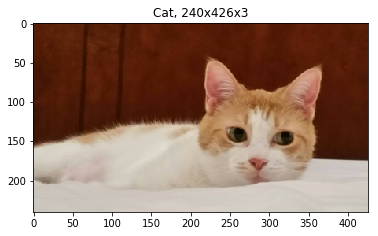

In [28]:
import scipy.ndimage as img
import scipy.fftpack as fft
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
cat400=img.imread('cat400.png')
plt.imshow(cat400)
plt.title('Cat, 240x426x3')



# Downsampling

Downsampling just means we remove $D-1$ out of every $D$ samples, thus
$$y[m,n,k]=x[mD,nD,k]$$

The result is usually aliasing.  In the Fourier transform domain, the aliasing is expressed by overlap of the spectrum:
$$Y(\omega) = \left(\frac{1}{D}\right)\sum_{d=0}^{D-1} X\left(\frac{\omega-2\pi d}{D}\right)$$

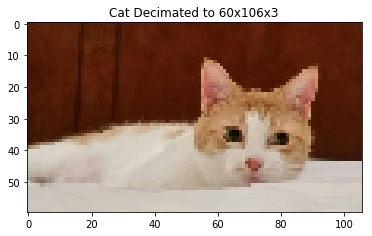

In [29]:
(M,N,K)=cat400.shape
cat100=np.zeros((int(M/4),int(N/4),K),dtype=cat400.dtype)
for m in range(0,int(M/4)):
    for n in range(0,int(N/4)):
        for k in range(0,K):
            cat100[m,n,k]=cat400[4*m,4*n,k]

plt.imshow(cat100)
plt.title('Cat Decimated to 60x106x3')

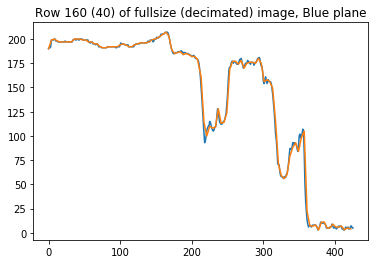

In [65]:
plt.figure()
t4=np.linspace(0,N-1,N,dtype='int16')
t1 = np.linspace(0,N-4,int(N/4),dtype='int16')
plt.plot(t4,cat400[160,:,2],t1,cat100[40,:,2])
plt.title('Row 160 (40) of fullsize (decimated) image, Blue plane')



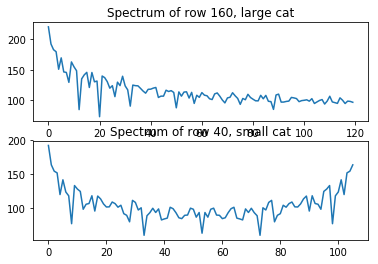

In [66]:
spec400=fft.fft(cat400[160,:,2])
spec100=fft.fft(cat100[40,:,2])
plt.subplot(211)
plt.plot(20*np.log(abs(spec400[0:120])))
plt.title('Spectrum of row 160, large cat')
plt.subplot(212)
plt.plot(20*np.log(abs(spec100[0:120])))
plt.title('Spectrum of row 40, small cat')

# Decimation
We can avoid aliasing by lowpass filtering the signal prior to downsampling.

An ideal lowpass filter with cutoff frequency $\omega_c$ is given by
$$h[n]=\frac{\omega_c}{\pi}\mbox{sinc}(\omega_c n)=\frac{\sin(\omega_c n)}{\pi n}$$
When we create a lowpass filter by hand, we have to be careful with the $n=0$ sample:
$$h[0]=\frac{\omega_c}{\pi}$$
In order to avoid aliasing, we need
$$\omega_c=\frac{\pi}{D}$$
We can approximate an ideal lowpass filter by creating a reasonably long, rectangular-windowed FIR filter
(Hamming window would be better).  Then we can lowpass filter by convolving each row and each column:
    $$x_{lpf}[n]=h[n]\ast x[n]$$
    $$y_{lpf}[n] = x_{lpf}[nD]$$

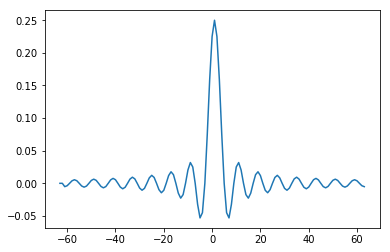

In [71]:
n_axis = np.linspace(-63,63,127,dtype='int16')
lpf = np.zeros(127)
zero_sample = 64
lpf[zero_sample]=0.25
for n in range(1,63):
    lpf[zero_sample+n]=np.sin(np.pi*n/4)/(np.pi*n)
    lpf[zero_sample-n]=lpf[zero_sample+n]
plt.plot(n_axis,lpf)

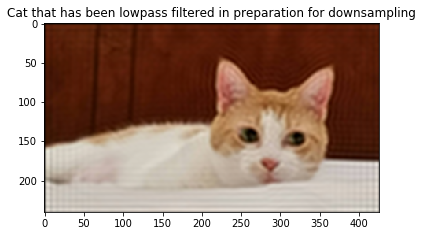

In [68]:
cat_half_filtered_double = np.zeros(cat400.shape)
cat_filtered_double = np.zeros(cat400.shape)
for k in range(0,K):
    for m in range(0,M):
        cat_half_filtered_double[m,:,k]=np.convolve(cat400[m,:,k],lpf,mode='same')
    for n in range(0,N):
        cat_filtered_double[:,n,k]=np.convolve(cat_half_filtered_double[:,n,k],lpf,mode='same')
cat_filtered = np.ndarray.astype(np.maximum(0,np.minimum(255,cat_filtered_double)),dtype='uint8')
plt.imshow(cat_filtered)
plt.title('Cat that has been lowpass filtered in preparation for downsampling')

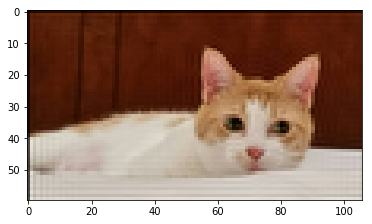

In [91]:
(M,N,K)=cat_filtered.shape
catf100=np.zeros((int(M/4),int(N/4),K),dtype=cat_filtered.dtype)
for m in range(0,int(M/4)):
    for n in range(0,int(N/4)):
        for k in range(0,K):
            catf100[m,n,k]=cat_filtered[4*m,4*n,k]

#plt.plot(t4,cat_filtered[160,:,2],t1,catf100[40,:,2])
#plt.title('Row 160 (40) of lowpass filtered (dowsampled) cat')
plt.imshow(catf100)

# Upsampling

Upsampling is the process of creating a larger image, from a smaller image, by just inserting zeros:
$$z[m,n,k] = \left\{\begin{array}{ll}
y[m/D,n/D,k] & m/D,~n/D~\mbox{are integers}\\
0 & \mbox{otherwise}
\end{array}\right.$$

Again, the problem is aliasing:
$$Z(\omega) = Y(D\omega)$$

This time, though, the aliasing is much more visible in the image.  In fact, the image is mostly black dots, with a few spots of color (one per $D\times D$ square).


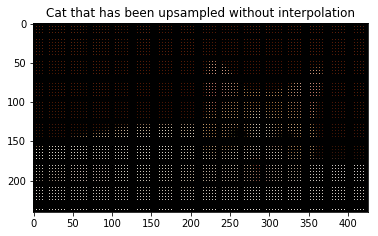

In [90]:
cat_upsampled = np.zeros(cat400.shape,dtype=cat400.dtype)
for m in range(0,int(M/4)):
    for n in range(0,int(N/4)):
        for k in range(0,K):
            cat_upsampled[4*m,4*n,k]=catf100[m,n,k]
plt.imshow(cat_upsampled)
plt.title('Cat that has been upsampled without interpolation')

#  Piece-wise constant interpolation

The solution is obvious: rather than just filling zeros between the upsampled samples, we need to fill in some meaningful value.
The first solution to consider is piece-wise constant interpolation, sometimes called zero-order hold (ZOH).

$$z[m,n,k]=y[\mbox{int}(m/D),\mbox{int}(n/D),k]$$

This results in some aliasing, but not as bad as the upsampled cat.

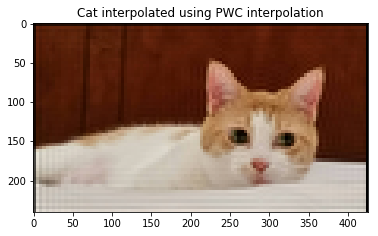

In [76]:
cat_pwc = np.zeros(cat400.shape,dtype=cat400.dtype)
for m in range(0,240):
    for n in range(0,424):
        for k in range(0,K):
            cat_pwc[m,n,k]=catf100[int(m/4),int(n/4),k]
plt.imshow(cat_pwc)
plt.title('Cat interpolated using PWC interpolation')

# Piece-wise linear (bilinear) interpolation

If piece-wise constant (PWC) interpolation is much better than upsampling, then piece-wise linear (PWL) interpolation should be much better.

PWL interpolation in two dimensions is called ``bilinear'' interpolation.  In this case the word ``bilinear'' just means linear
in two different directions.  

A sample $z[m,n]$ in the output is closest to four different samples of the input: $y\left[\mbox{int}\left(\frac{m}{D}\right),\mbox{int}\left(\frac{n}{D}\right)\right]$,
$y\left[\mbox{int}\left(\frac{m}{D}\right)+1,\mbox{int}\left(\frac{n}{D}\right)\right]$, $y\left[\mbox{int}\left(\frac{m}{D}\right),\mbox{int}\left(\frac{n}{D}\right)+1\right]$, and $y\left[\mbox{int}\left(\frac{m}{D}\right)+1,\mbox{int}\left(\frac{n}{D}\right)+1\right]$.  The first thing to do is to calculate the fractional contribution of each of these four samples to the 
output:
$$e = \frac{m}{D} - \mbox{int}\left(\frac{m}{D}\right)$$
$$f = \frac{n}{D} - \mbox{int}\left(\frac{n}{D}\right)$$

Then we can create the output sample as

$$z[m,n,k] = \left(1-e\right)\left(1-f\right)\times y\left[\mbox{int}\left(\frac{m}{D}\right),\mbox{int}\left(\frac{n}{D}\right),k\right]
+ e\left(1-f\right)\times y\left[\mbox{int}\left(\frac{m}{D}\right)+1,\mbox{int}\left(\frac{n}{D}\right),k\right]$$
$$+ \left(1-e\right)f \times y\left[\mbox{int}\left(\frac{m}{D}\right),\mbox{int}\left(\frac{n}{D}\right)+1,k\right]+ ef\times y\left[\left(\frac{m}{D}\right)+1,\left(\frac{n}{D}\right)+1,k\right]$$


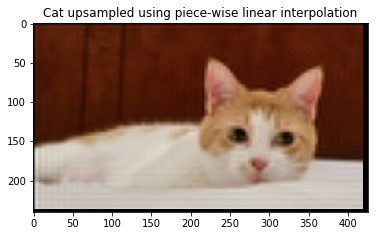

In [81]:
cat_pwl_double = np.zeros(cat400.shape,dtype='double')
for m in range(0,236):
    for n in range(0,420):
        for k in range(0,K):
            m1 = int(m/4)
            n1 = int(n/4)
            e = 0.25*m - m1
            f = 0.25*n - n1
            z = (1-e)*(1-f)*catf100[m1,n1,k]+e*(1-f)*catf100[m1+1,n1,k]+(1-e)*f*catf100[m1,n1+1,k]+e*f*catf100[m1+1,n1+1,k]
            cat_pwl_double[m,n,k]=z
cat_pwl = np.ndarray.astype(np.maximum(0,np.minimum(255,cat_pwl_double)),dtype='uint8')
plt.imshow(cat_pwl)
plt.title('Cat upsampled using piece-wise linear interpolation')

Notice that piece-wise-linear interpolation is just like upsampling the cat, and then convolving with the piece-wise linear interpolation filter:

$$h_{PWL}[n] = \left\{\begin{array}{ll}
\frac{D-|n|}{D} & -D\le n\le D\\
0 & \mbox{otherwise}\end{array}\right.
$$

Similarly, piece-wise constant interpolation is just like upsampling the cat, and then convolving with the piece-wise constant interpolation filter:

$$h_{PWC}[n] = \left\{\begin{array}{ll} 1 & 0\le n<D\\
0 & \mbox{otherwise}\end{array}\right.$$

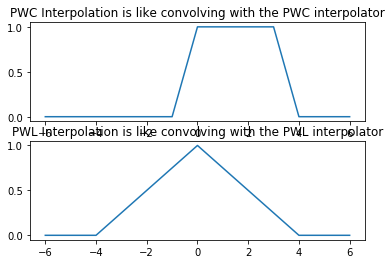

In [85]:
zero_sample = 6
n_axis = np.linspace(-zero_sample,zero_sample, 2*zero_sample+1, dtype='int16')
h_pwc = np.zeros(13)
h_pwl = np.zeros(13)
for n in range(0,4):
    h_pwc[zero_sample+n]=1
    h_pwl[zero_sample+n]=0.25*(4-n)
    h_pwl[zero_sample-n]=0.25*(4-n)
plt.subplot(211)
plt.plot(n_axis,h_pwc)
plt.title('PWC Interpolation is like convolving with the PWC interpolator')
plt.subplot(212)
plt.plot(n_axis,h_pwl)
plt.title('PWL Interpolation is like convolving with the PWL interpolator')

# Sinc Interpolation

PWC interpolation suffers from obvious blocky artifacts.  PWL interpolation smooths away most of those, but not all.
We can get rid of all of them, and get the lowpass-filtered cat back again exactly, by filtering the upsampled cat
using an ideal sinc function.

$$z[n]=D^2  h_{LPF}[n]\ast y[n]$$

Multiplying by a factor of $D^2$ is necessary because we're trying to construct $D^2$ output samples from every one input sample. 

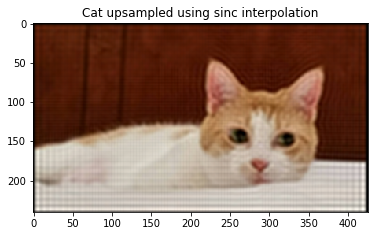

In [89]:
cat_si_double=np.zeros(cat400.shape,dtype='double')
for k in range(0,K):
    for m in range(0,M):
        cat_half_filtered_double[m,:,k]=4*np.convolve(cat_upsampled[m,:,k],lpf,mode='same')
    for n in range(0,N):
        cat_si_double[:,n,k]=4*np.convolve(cat_half_filtered_double[:,n,k],lpf,mode='same')
cat_si = np.ndarray.astype(np.maximum(0,np.minimum(255,cat_si_double)),dtype='uint8')
plt.imshow(cat_si)
plt.title('Cat upsampled using sinc interpolation')

# Remaining artifacts
Notice that the kitty above still has some ringing artifacts.  Those are edge effects, caused by using an FIR approximation
to the ideal lowpass filter.  Many of them would go away if we used a Hamming-windowed filter instead.